In [17]:
import pandas as pd
import numpy as np
from scipy.cluster.vq import kmeans,vq,whiten

In [18]:
df = pd.read_csv('HealthViz County Dataset 6 21 17.csv', skiprows=0, header=1, index_col=0, encoding = "ISO-8859-1")
df.index.name=None

In [19]:
df.dropna(axis=0, how='any', inplace=True)
df.drop(df.columns[[0]], axis=1, inplace=True) #drop 'County'

In [20]:
def split_df(df, num, col_population):
    '''
    Split dataframe into desired number of groups based on the population
        num: int
        col_population: string, e.g 'Population (residents), 2011-2015'
        
        return: a list of sub dataframes
    '''
    rows, cols = df.shape
    size = int(round(rows/num, 0))
    df = df.sort_values(col_population, ascending=True)
    l = []
    for g, df in df.groupby(np.arange(len(df)) // size):
        l = l + [df]
    if len(l) > num:
        df1 = l[-1]
        df2 = l[-2]
        df3 = df2.append(df1)
        l = l[: -2]
        l = l + [df3]
    return l


In [21]:
# for check
l = split_df(df, 10, 'Population (residents), 2011-2015')
for i in l:
    print(i.shape)

(248, 17)
(248, 17)
(248, 17)
(248, 17)
(248, 17)
(248, 17)
(248, 17)
(248, 17)
(248, 17)
(250, 17)


In [22]:
# elbow effect to choose K in K-means
# sum of squared error (SSE): sum of the squared distance between each member of the cluster and its centroid

# Get K function
def get_k(df, size):
    '''
    Using the size of each cluster to determine the number of clusters, which is K
        size: int
    '''
    rows, cols = df.shape
    k = int(round(rows/size, 0))
    return k


from scipy.cluster.vq import kmeans,vq,whiten
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

def check_k(df, k, graph_range):
    '''
    range(1, 100)
    '''
    a,b = graph_range
    K = range(a,b)
    X = whiten(df)
    KM = [kmeans(X,k) for k in K]
    centroids = [cent for (cent,var) in KM]
    D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
    #cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/X.shape[0] for d in dist]
    l = []
    for i in range(a-1, b-2):
        rate = abs(avgWithinSS[i+1] - avgWithinSS[i])/avgWithinSS[i]
        l = l + [rate]
    k_changing_rate = l[k-2]
    
    kIdx = k-1
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
        markeredgewidth=2, markeredgecolor='r', markerfacecolor='None') #K[kIdx] [kIdx]
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    return k_changing_rate

12


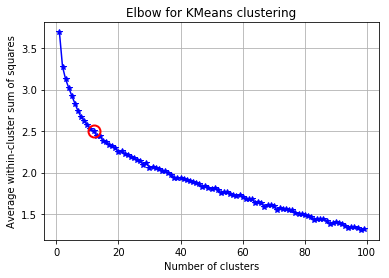

0.010222702418736008

In [23]:
df1 = l[0]
k = get_k(df1, 20)
print (k)
graph_range = (1,100)
check_k(df1, k, graph_range)

In [8]:
# get the clustering table
from sklearn.cluster import KMeans
import numpy as np
def get_k_means(df,k):
    X = whiten(df)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    df['label'] = kmeans.labels_.tolist()
    return df

In [9]:
ddf = get_k_means(df1, k)

In [14]:
ddf.groupby('label').size()

label
0     16
1      1
2     11
3     40
4     46
5     13
6     41
7     42
8     16
9      6
10    12
11     4
dtype: int64

In [15]:
ddf = ddf.sort_values('label', ascending=True)

In [16]:
ddf
# to be done
# after sorted df based on 'label', with a loop for the label, using = to get each group, 
# then get the indices of each group

,"Diabetes mortality (deaths per 100,000), 2008-2014","Population (residents), 2011-2015","Population, Non-Hispanic Black (residents), 2011-2015","Population, Hispanic or Latino (residents), 2011-2015","Population, Asian or Pacific Islander (residents), 2011-2015","Median age, 2011-2015","Age dependency ratio (Dependents per 100 working-age adults), 2011-2015","Median household income, 2011-2015","Poverty rate (% of residents), 2011-2015","Share of income, top 5% (% of total income), 2011-2015","Dual eligible coverage (% of residents), 2010-2014","College graduation rate (% of residents), 2011-2015","Graduate education rate (% of residents), 2011-2015","Food stamps (SNAP) (% of households), 2011-2015","Public assistance income (cash welfare) (% of households), 2011-2015","Total election votes (Presidential) (votes), 2016","Election margin, winner (Presidential) (% margin), 2016",label
40075,40.2,9302,361,966,29,43.0,73.674384,39861.50829,20.838867,25.31,3.719865,18.750000,5.555556,19.446560,2.030972,3489.0,52.364574,0
40141,53.4,7715,614,1885,18,40.5,73.604860,37714.06679,23.777174,19.92,3.956014,16.740004,4.859384,20.902846,3.598299,2706.0,47.560976,0
48437,34.4,7713,491,3219,27,36.1,76.176336,36995.92240,22.579275,20.76,2.427117,15.920097,4.761905,16.383963,0.154202,2190.0,55.205479,0
8021,37.5,8249,8,4484,14,38.4,79.991272,36608.38412,18.269820,18.49,6.548199,19.482726,4.965075,20.895522,6.173677,3970.0,3.324937,0
13253,54.3,8769,2937,252,48,45.1,75.415083,34863.46305,18.422268,19.41,3.768815,15.134603,6.089954,19.176007,1.575280,3577.0,32.345541,0
48107,51.2,6007,233,3235,0,38.2,83.475870,37389.45354,22.935315,21.80,2.584023,11.726469,2.574103,21.196894,3.471905,1712.0,41.588785,0
48075,42.3,7059,680,1447,133,34.6,52.990897,36589.40673,20.212949,18.06,0.000000,16.749896,5.181024,13.592639,4.642409,2084.0,74.328215,0
46023,40.3,9239,4,232,17,37.3,89.829464,43057.70029,22.087678,20.41,1.870616,18.268896,5.033090,16.083254,4.982655,3433.0,42.149723,0
51530,46.8,6666,70,91,473,33.8,60.048019,29062.37457,28.421053,18.91,2.134100,16.439357,5.455431,17.647059,1.607600,2395.0,30.855950,0
30085,37.9,11072,9,127,21,30.4,74.225020,32934.76094,27.752653,22.12,1.613508,13.475629,3.456515,14.920013,5.746001,3486.0,6.253586,0
